In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from math import ceil
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

%matplotlib inline
warnings.filterwarnings('ignore')

#plt.rcParams['figure.figsize'] = 16, 8

In [424]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4190,13696,3,1.0,29.251769,15.750583,6.0,9,12.0,1975,0.050900,B,B,43,10621,1,30.0,2,3,B,144673.313003
5308,8957,1,2.0,51.864120,NaN,0.0,10,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,155677.692011
7360,12141,53,1.0,38.156315,38.957149,1.0,12,19.0,2017,0.049637,B,B,34,7759,0,229.0,1,3,B,242866.633362
6598,5867,27,3.0,54.036946,NaN,1.0,11,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,178034.514310
6697,5655,132,2.0,48.725638,35.627682,5.0,3,5.0,1965,0.007659,B,B,35,7077,56,2301.0,3,19,B,240010.277666
5609,3904,11,3.0,60.451104,37.239782,5.0,4,9.0,1974,0.012339,B,B,35,5776,1,2078.0,2,4,B,230175.180494
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275
7763,15621,84,1.0,34.908632,22.908750,7.0,7,5.0,1960,0.149666,B,B,22,4789,2,4087.0,4,1,B,169001.649683
3960,7761,106,3.0,82.480130,52.187231,9.0,2,9.0,1957,0.313925,B,B,22,4625,11,3855.0,2,10,B,338792.844921
7276,13982,200,1.0,42.459586,19.971330,9.0,5,22.0,2011,0.000000,B,B,33,7425,1,NaN,2,5,B,253961.994224


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [425]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Exploratory data analysis

In [426]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [427]:
# кол-во значений в признаках
# переведем признаки с небльшим кол-во значений в категориальные
pd.DataFrame({item:len(train_data[item].unique()) for item in train_data[train_data.columns.tolist()].select_dtypes(include=['int64', 'float64']).columns.tolist()}.items(), \
columns = ['Name', 'Count']).sort_values(by='Count').head(13)

,Name,Count
14,Helthcare_2,7
2,Rooms,9
15,Shops_1,16
12,Social_3,30
6,Floor,33
7,HouseFloor,44
10,Social_1,51
5,KitchenSquare,58
13,Healthcare_1,80
8,HouseYear,97


### класс конвейера

In [428]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def column_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['int64', 'float64']).columns.tolist()
        
    @property    
    def column_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()    
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # срнднйи уровень корреляции
        self.corr = 0.5
        # пороговое значение в три сигмы
        self.threashold = 3    
        # пропорции деления набора
        self.test_size = .33
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, key, value)                        
            
        assert self.train_file is not None
        self.train_data = DataFrame(pd.read_csv(self.train_file))
        
        assert self.test_file is not None                   
        self.test_data = DataFrame(pd.read_csv(self.test_file))
        
        assert self.feature is not None
        
    @property
    def r2(self):
        """коэффициент детерминации"""
        return self.__r2__        
    
    def sc_data(func):
        """Декоратор стандартизации"""
        def wrapper(self):         
            scaler = StandardScaler()                                    
            
            # стандартизация обучения                    
            self.train_data = func(self, self.train_data)
            # добавление признаков
            self.train_data = self.feature.create(self.train_data)
            # количественные признаки
            column = [item for item in self.train_data.column_num if item != self.target]               
            # стандартизация признаков
            self.sc_train_data = DataFrame(scaler.fit_transform(self.train_data[column]), columns=column)
            # понижение размерности
            self.sc_train_data = DataFrame(self.resize(self.sc_train_data))
            # объединение номинальных и количественных признаков
            self.train_data = DataFrame(pd.concat([self.train_data[self.train_data.column_cat], self.sc_train_data, \
                                                   self.train_data[self.target]], axis=1))
            
            # стандартизация теста
            self.test_data = func(self, self.test_data)            
            # добавление признаков
            self.test_data = self.feature.create_blank(self.test_data)
            # количественные признаки
            column = [item for item in self.test_data.column_num if item != self.target]            
            # стандартизация признаков
            self.sc_test_data = DataFrame(scaler.transform(self.test_data[column]), columns=column)
            # понижение размерности
            self.sc_test_data = DataFrame(self.resize(self.sc_test_data))
            # объединение номинальных и количественных признаков
            self.test_data = DataFrame(pd.concat([self.test_data[self.test_data.column_cat], self.sc_test_data], axis=1))
                        
        return wrapper    
    
    @sc_data
    def transform(self, data):       
        """Трансформация данных"""  
        # удаляем id
        data.drop("Id", axis=1, inplace=True)            
        # значений не много переводим в категориальный тип
        data.DistrictId = data.DistrictId.astype("category")
        
        data.Social_1 = data.Social_1.astype("category")
        data.Social_2 = data.Social_2.astype("category")
        data.Social_3 = data.Social_3.astype("category")

        data.Shops_1 = data.Shops_1.astype("category")
        data.Shops_2 = data.Shops_2.astype("category")
        
        data.Healthcare_1 = data.Healthcare_1.astype("category")
        data.Helthcare_2  = data.Helthcare_2.astype("category")

        # обработка номинальных признаков
        for item in data.column_cat:        
            data = self._transform_cat_(data, item)            
        # обработка количественных признаков
        for item in data.column_num:
            data = self._transform_num_(data, item)                
        
        return data
            
    def _transform_cat_(self, data, column):
        """Трансформация номинальных признаков"""                
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # кодируем признак
        data[column] = LabelEncoder().fit_transform(data[column])
        # возвращаем тип признака из числового после кодирования
        data[column] = data[column].astype("category")
        
        return data
        
    def _transform_num_(self, data, column):
        """Трансформация количественных признаков"""                      
        # запомнинание пропусков
        data['isna'] = np.where(data[column].isna(), True, False)                        
        # заполнение пропусков
        data[column] = data[column].fillna(data[column].mean())
        # обработка выбрасов, вычисляем z-Score в цикле пока не подавим их все       
        while True:
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] > self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].mean()            
            else:            
                data.loc[z > self.threashold, column] = data[column].median()                                              
        # винсоризация, zscore почему-то не убирает некоторые значительные выбросы
        #data[column] = winsorize(data[column], limits=[0.1, 0.1])                                      
        # обработка пропусков             
        if True in data['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем обучающие и тестовые наборы
            X_test = data[data['isna']==True][[item for item in data.columns if item != column]]
            X_train = data[data['isna']==False][[item for item in data.columns if item != column]]        
            y_train = data[data['isna']==False][[column]]        
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание прзнака
            data[data['isna']][column] = model.predict(X_test)            
        data.drop('isna', axis=1, inplace=True)            
        
        return data
    
    def resize(self, data):
        """понижение размерности"""
        m_corr, drop_cols = data.corr(), set()        
        # поиск сильных взаимных корреляций признаков
        for item in m_corr.columns:    
            column = list(m_corr[m_corr[item] > self.corr].index)
            if len(column) > 1:
                for item in column:
                    drop_cols.add(item)
        
        dim_reducer = PCA(n_components=1, random_state=42)

        components = dim_reducer.fit_transform(data[list(drop_cols)])                    

        return DataFrame(pd.concat([data.drop(list(drop_cols), axis=1),\
                                   pd.DataFrame(data = components, columns = ['component_1'])], axis=1))
    
    def split(self, data):
        """Разделение набора"""
        X = data[[item for item in data.columns if item != self.target]]
        y = data[[self.target]]
                
        return train_test_split(X, y, test_size=self.test_size, random_state=42)
    
    def search_param(self, data):
        """Поиск гиперпараметров"""
        
        parameters = {
            'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson', 'gini', 'entropy'],
            'n_estimators': [item for item in range(10, 100, 10)],            
            'max_depth': [item for item in range(1, 10, 2)],
            'max_features': [item for item in range(1, 10, 2)]            
        }

        clf = GridSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_grid=parameters,            
            scoring='r2',
            n_jobs=-1,
            cv=5
        )              
        # формируем X и y из обучающего набора
        X_train, X_valid, y_train, y_valid = self.split(self.train_data)
        # искать праметры лучше на всеъ данных
        clf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
        
        return clf.best_params_
    
    def fit(self, parameters):
        """Обучение модели"""         
        model = RandomForestRegressor(**parameters)
        
        X_train, X_valid, y_train, y_valid = self.split(self.train_data)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        self.__r2__ = r2_score(y_valid, y_pred)
        
        return model
        
    def predict(self, model):
        """Предсказание зависимой переменной"""
        return model.predict(self.test_data)    
    
    def importances(self, model):
        """оценка признаков модели"""
        return pd.DataFrame(zip(self.train_data.columns, model.feature_importances_),\
                            columns = ['name', 'value']).sort_values(by = 'value', ascending = False)
        
    def plot(self, data):      
        """график plot"""    
        data[[item for item in data.column_num if item != self.target]].hist(figsize=(16,16), bins=20, grid=False);
        
        plt.figure(figsize = (16, 8))
        sns.distplot(data[self.target], bins=50)                        
        target_mean = round(data[self.target].mean(), 2)
        target_median = data[self.target].median()
        target_mode = data[self.target].mode()[0]        

        y = np.linspace(0, 0.000005, 10)
        plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

        plt.title(f'Distribution of {self.target}')
        plt.legend()            
        plt.show()        

    def boxplot(self, data):
        """график box-plot"""           
        plt.figure(figsize = (16, 8))
        data.boxplot(column=[item for item in data.column_num if item != self.target])
        
    def corrplot(self, data):
        """график корреляции"""
        plt.figure(figsize = (16, 8))
        plt.title('Корреляционная матрица')
        sns.heatmap(data.corr(), annot = True)
        plt.show()  
        
class Features:
    """Генератор признаков"""
    def create(self, data):
        data = data.merge(data.groupby(['DistrictId', 'HouseYear'], as_index=True).agg({'Price':'median'}).\
                          rename(columns={'Price':'PriceByDistrict'}).reset_index(), on=['DistrictId', 'HouseYear'], how='left')        
                      
        return DataFrame(data)
    
    def create_blank(self, data):
        data['PriceByDistrict'] = 0        
        
        return DataFrame(data)            

In [429]:
# создамие конвейера
pipeline = DataPipeline(feature=Features(), train_file="train.csv", test_file="test.csv", target='Price')

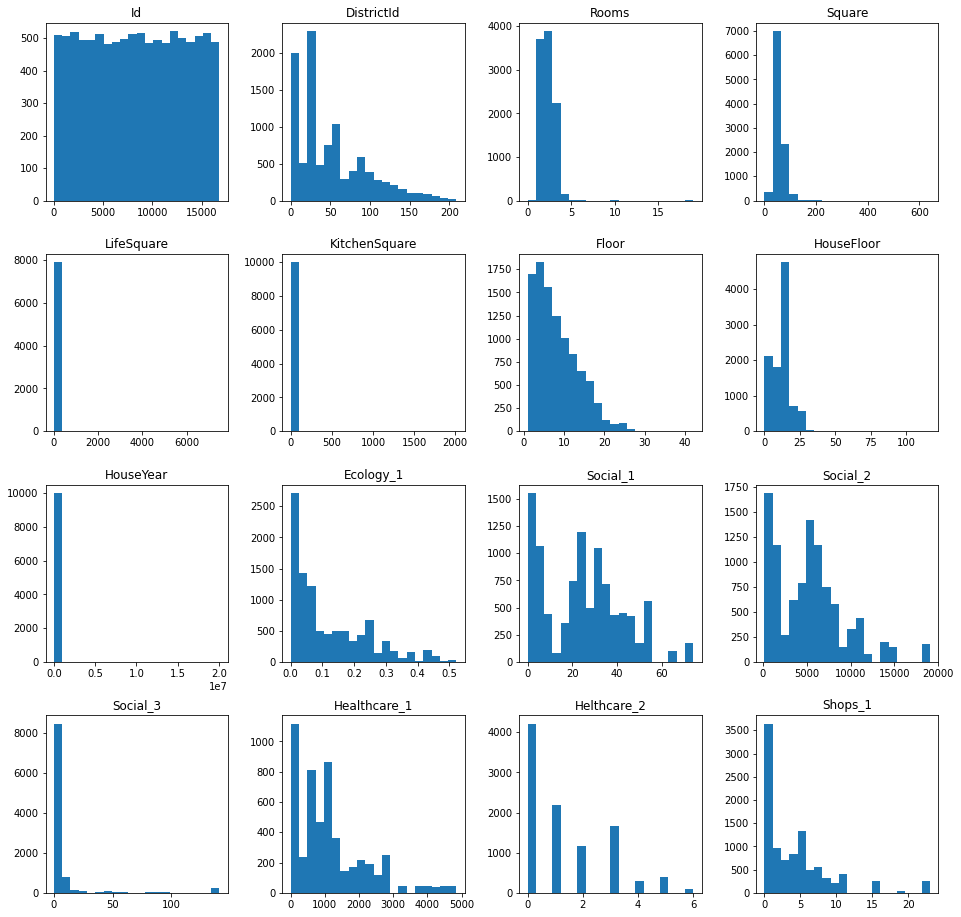

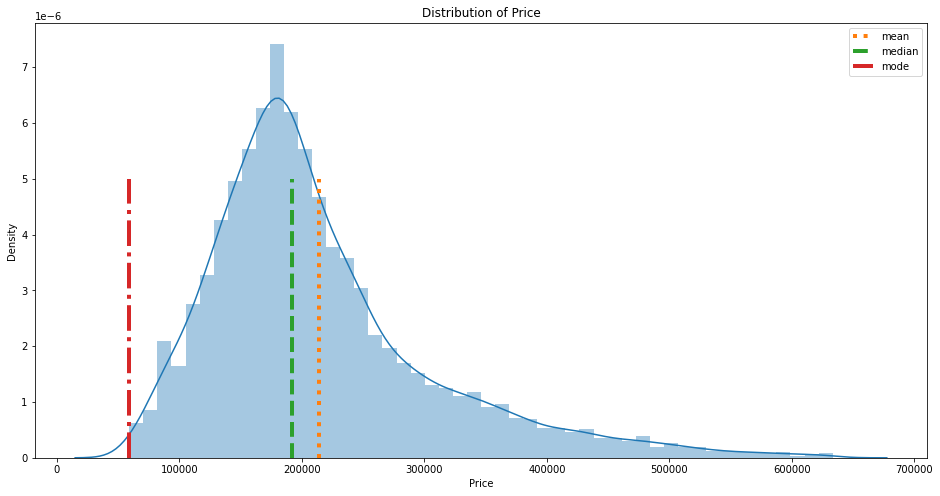

In [430]:
pipeline.plot(pipeline.train_data)

In [431]:
# подготовка признаков
pipeline.transform()

<Figure size 1152x576 with 0 Axes>

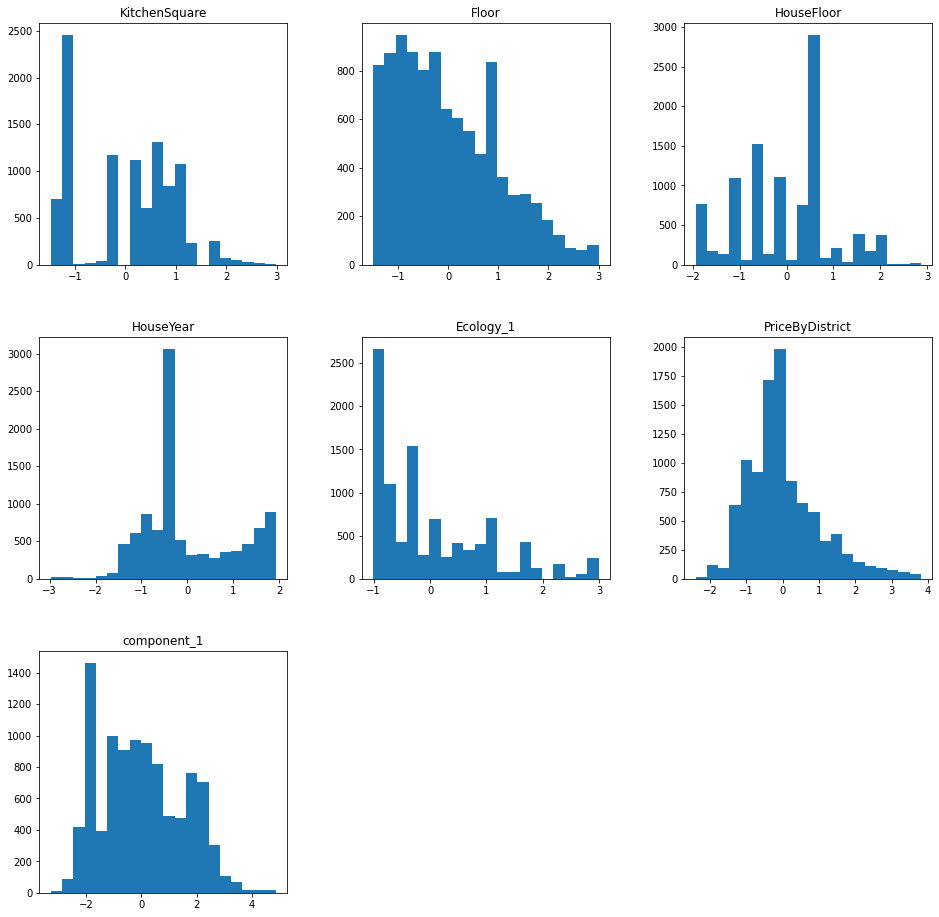

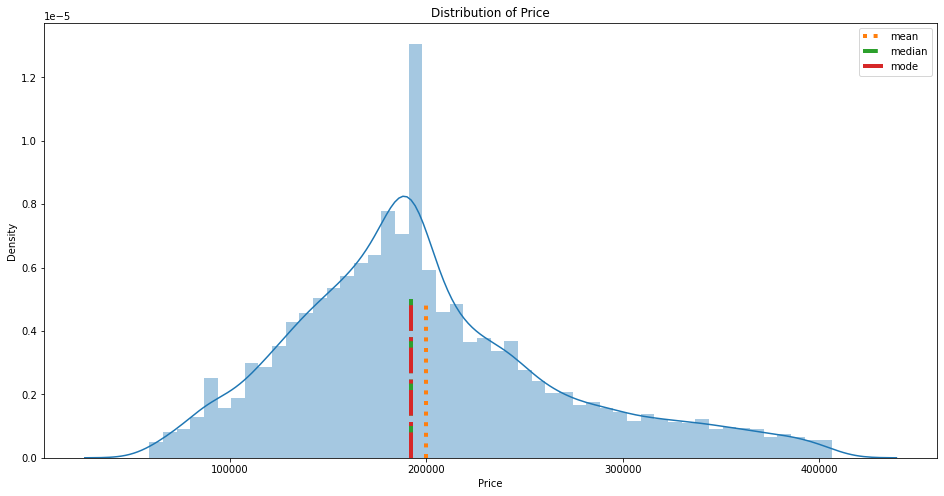

In [432]:
plt.figure(figsize = (16, 8))
# распределение количественных признаков в исходных данных и осноные статистические данные в них
pipeline.plot(pipeline.train_data)

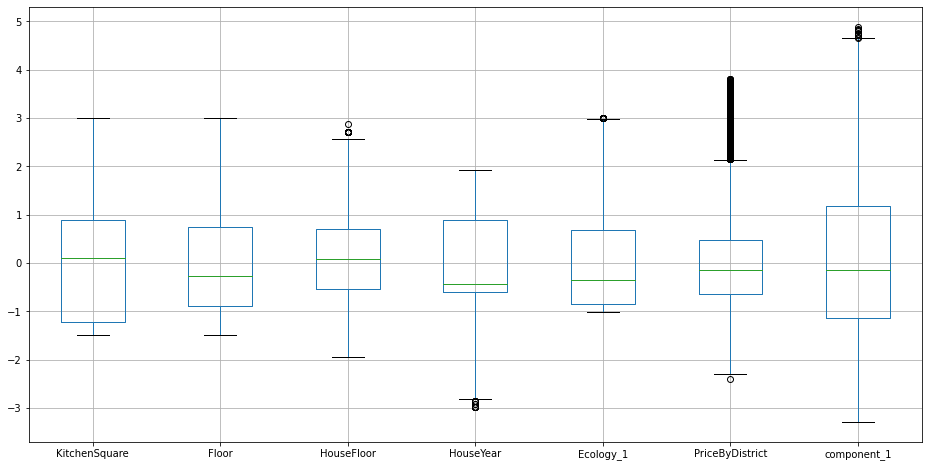

In [433]:
pipeline.boxplot(pipeline.sc_train_data)

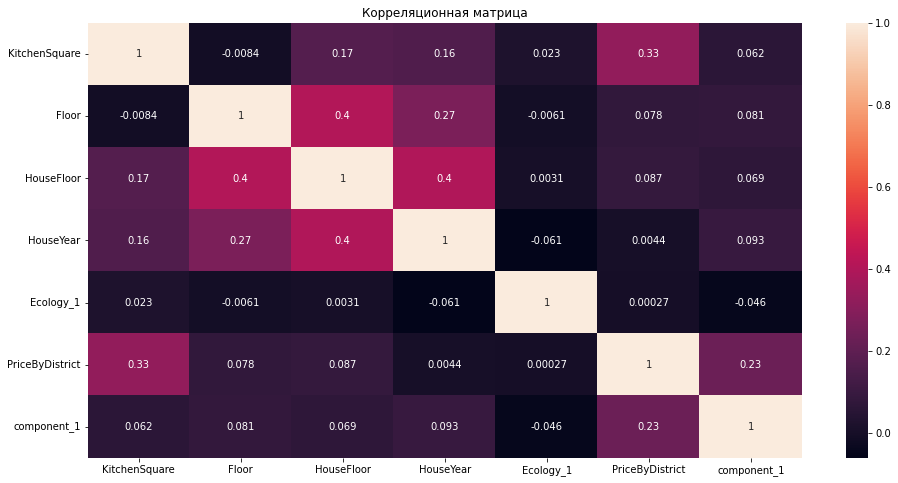

In [434]:
pipeline.corrplot(pipeline.sc_train_data)

In [435]:
%%time
#model = pipeline.fit(pipeline.search_param(pipeline.train_data))

Wall time: 0 ns


In [438]:
model = pipeline.fit({'criterion': 'friedman_mse', 'max_depth': 9, 'max_features': 7, 'n_estimators': 70, 'random_state': 42})

print(f"R2={pipeline.r2:.2f}")

pipeline.importances(model).head(5)

R2=0.75


,name,value
15,PriceByDistrict,0.498552
16,component_1,0.255813
3,Social_1,0.065890
4,Social_2,0.046355
10,KitchenSquare,0.022921


In [437]:
pd.concat([pipeline.test_data, pd.DataFrame(data = pipeline.predict(model), columns = ['Price'])], axis=1)   

,DistrictId,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,PriceByDistrict,component_1,Price
0,57,1,1,11,35,1,22,0,0,1,0.096170,-0.471125,0.229689,-0.715427,1.685900,-3.568421,-0.168603,115265.494359
1,73,1,1,6,19,3,22,0,2,1,-1.219789,-0.471125,-1.786485,-0.440038,-0.351403,-3.568421,0.699452,159622.101262
2,184,1,1,30,116,27,77,5,5,1,1.675321,-1.287491,-1.166124,-0.440038,-1.009981,-3.568421,-3.095227,104389.875488
3,47,1,1,23,65,3,22,3,3,1,0.885746,2.794339,1.470411,1.212294,-0.124627,-3.568421,1.565999,137473.344833
4,27,1,1,2,11,1,22,0,0,0,-1.219789,1.773881,0.694960,1.763071,-0.382874,-3.568421,-0.539406,133325.359926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,1,1,36,94,0,22,1,1,1,0.096170,-0.675216,-0.545763,-0.660349,-1.008507,-3.568421,2.022972,147857.823460
4996,1,1,1,1,2,0,22,0,1,1,1.148937,0.753424,0.694960,1.763071,-0.948083,-3.568421,-1.807003,101376.291195
4997,12,1,1,50,142,2,22,5,12,1,0.885746,2.998430,1.470411,0.220895,-0.220864,-3.568421,2.318226,183797.475655
4998,61,1,1,2,11,1,22,0,0,0,-1.482980,-0.879308,-1.941576,-0.440038,-0.382874,-3.568421,1.161390,164811.645212
